Using Gee and ee (google earth engine) this file is importing SAR level 1 datas and convert it into the TIF files of regions that we are interested in. After downloading the files, one can integrate and analyze it to generate pixel datas and histograms, to calculate its FDI or RVI. 

In [14]:
# Step 1: Install and import necessary libraries
# The geemap library makes working with Google Earth Engine in Python much easier.
# !pip install geemap
import ee
import geemap

# Step 2: Authenticate and initialize the Earth Engine library.
# This will prompt you to log in with a Google account and grant permissions.

# Corrected code
# Replace 'your-project-id-goes-here' with your actual Project ID
project_id = 'geesecrossing'

try:
    ee.Initialize(project=project_id)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=project_id)

print("Authentication and initialization successful!")

Authentication and initialization successful!


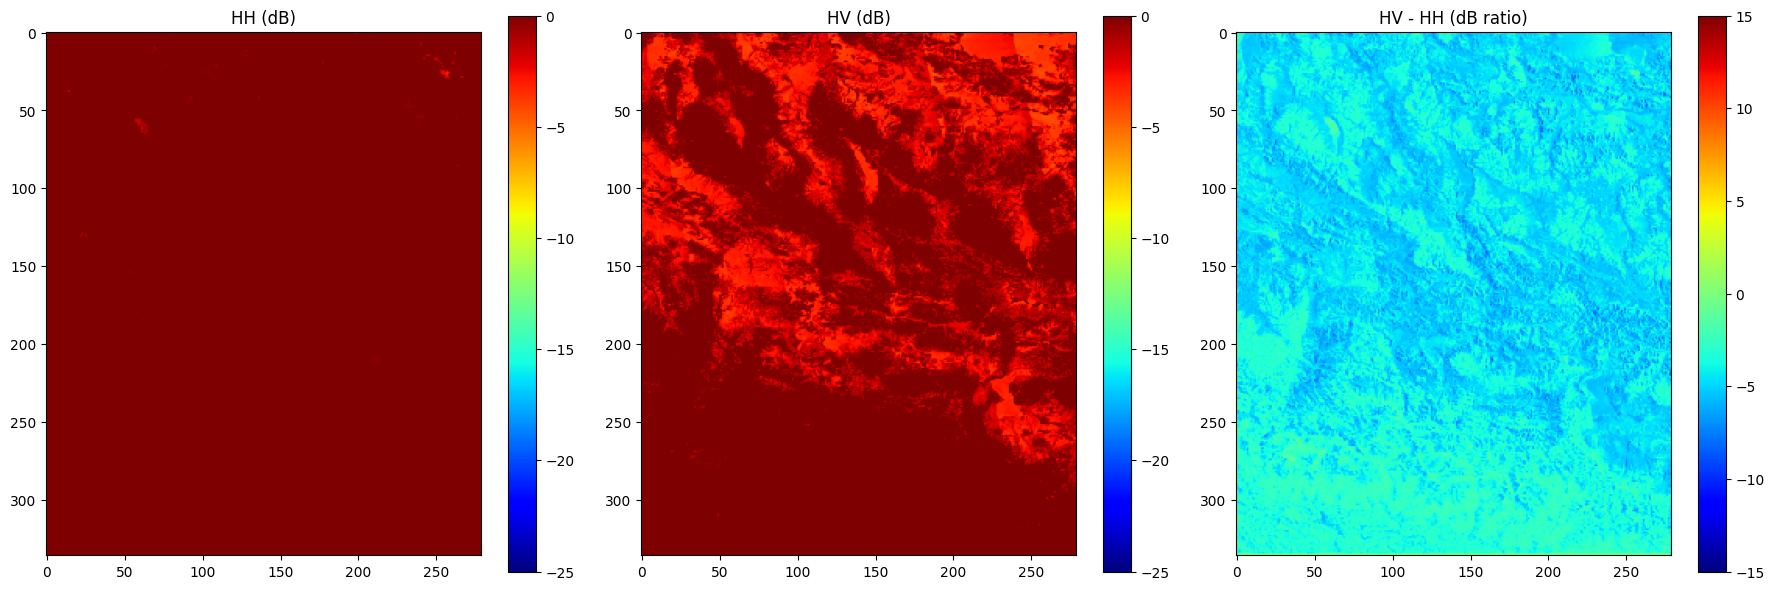

In [2]:
import geemap
import ee
import matplotlib.pyplot as plt

# GEE Ï¥àÍ∏∞Ìôî
ee.Initialize(project=project_id)
roi = ee.Geometry.Polygon( [[[83.5, 31], [83.5, 28.0], [86.0, 28.0], [86.0, 31]]] )
# ALOS PALSAR 2008 Mosaic
alos = ee.ImageCollection("JAXA/ALOS/PALSAR/YEARLY/SAR") \
           .filterDate("2008-01-01", "2008-12-31") \
           .mosaic().clip(roi)

# DN ‚Üí dB Î≥ÄÌôò
hh_dB = alos.select('HH').multiply(0.001).log10().multiply(10)
hv_dB = alos.select('HV').multiply(0.001).log10().multiply(10)
ratio = hv_dB.subtract(hh_dB)   # HV/HH ÎπÑÏú®ÏùÑ dB Ï∞®Ïù¥Î°ú ÌëúÌòÑ
resolution = 1000
# numpy arrayÎ°ú Î≥ÄÌôò (roi ÏòÅÏó≠ÏóêÏÑú export)
hh_array = geemap.ee_to_numpy(hh_dB, region=roi, scale=resolution)
hv_array = geemap.ee_to_numpy(hv_dB, region=roi, scale=resolution)
ratio_array = geemap.ee_to_numpy(ratio, region=roi, scale=resolution)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im1 = axes[0].imshow(hh_array, cmap='jet', vmin=-25, vmax=0)
axes[0].set_title("HH (dB)")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(hv_array, cmap='jet', vmin=-25, vmax=0)
axes[1].set_title("HV (dB)")
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(ratio_array, cmap='jet', vmin=-15, vmax=15)
axes[2].set_title("HV - HH (dB ratio)")
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()


In [3]:
import shutil, os

out_dir = "/content/ALOS_PALSAR_2008_tiles_1deg"
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)  # Ìè¥Îçî ÌÜµÏß∏ ÏÇ≠Ï†ú
os.makedirs(out_dir, exist_ok=True)
print("üìÇ Ï†ÄÏû• Í≤ΩÎ°ú Ï¥àÍ∏∞Ìôî ÏôÑÎ£å:", out_dir)


import numpy as np

def plot_with_scaling(array, ax, title, band_type="hh", cmap="jet"):
    # NaN Ï†úÍ±∞
    if array is None or np.all(np.isnan(array)):
        ax.set_title(f"{title} (no data)")
        return None

    # Î∞¥Îìú ÌÉÄÏûÖÎ≥Ñ Í≥†Ï†ï Ïä§ÏºÄÏùº
    if band_type.lower() == "hh" or band_type.lower() == "hv":
        vmin, vmax = -25, 0
    elif band_type.lower() == "ratio":
        vmin, vmax = -15, 15
    else:
        vmin, vmax = np.nanmin(array), np.nanmax(array)  # fallback

    im = ax.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    return im


üìÇ Ï†ÄÏû• Í≤ΩÎ°ú Ï¥àÍ∏∞Ìôî ÏôÑÎ£å: /content/ALOS_PALSAR_2008_tiles_1deg


In [10]:
# Sentinel-1 Îç∞Ïù¥ÌÑ∞ Í∞úÏàò ÌôïÏù∏
sentinel_count = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(roi_himalaya) \
    .filterDate("2018-01-01", "2018-12-31") \
    .size() \
    .getInfo()

print("Sentinel-1 Ïù¥ÎØ∏ÏßÄ Ïàò:", sentinel_count)


Sentinel-1 Ïù¥ÎØ∏ÏßÄ Ïàò: 8547


In [5]:
import ee
import geemap
import os

# GEE Ï¥àÍ∏∞Ìôî
ee.Initialize(project=project_id)
# ÌûàÎßêÎùºÏïº ROI (Ï†ÅÎãπÌûà ÌÅ∞ Î≤îÏúÑ)
anglerange = [75, 25, 100, 40]
roi_himalaya = ee.Geometry.Rectangle(anglerange)

# =============================
# Î∞¥Îìú ÏÑ†ÌÉù
# Î∞¥Îìú ÌÉÄÏûÖ ÏÑ†ÌÉù: "cband" or "lband"
band_name = "cband"   # Î∞îÍøîÍ∞ÄÎ©¥ÏÑú Ïã§Ìñâ

if band_name.lower() == "cband":
    # =============================
    # Sentinel-1 (C-band, VV/VH)
    # =============================
    sentinel = (
        ee.ImageCollection("COPERNICUS/S1_GRD")
          .filterBounds(roi_himalaya)
          .filterDate("2018-01-01", "2018-12-31")   # Sentinel-1ÏùÄ 2014ÎÖÑ Ïù¥ÌõÑ ÏûêÎ£åÎßå Ï°¥Ïû¨
          .filter(ee.Filter.eq("instrumentMode", "IW"))
          .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
          .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))
          .median()
          .clip(roi_himalaya)
    )

    vv_dB = sentinel.select("VV").log10().multiply(10).rename("VV_dB")
    vh_dB = sentinel.select("VH").log10().multiply(10).rename("VH_dB")
    ratio = vh_dB.subtract(vv_dB).rename("VH_VV_ratio")

    final_image = vv_dB.addBands(vh_dB).addBands(ratio)
    band_for_count = vv_dB  # ÌîΩÏÖÄ Ïπ¥Ïö¥Ìä∏Ïö© Î∞¥Îìú

elif band_name.lower() == "lband":
    # =============================
    # ALOS PALSAR (L-band, HH/HV)
    # =============================
    alos = (
        ee.ImageCollection("JAXA/ALOS/PALSAR/YEARLY/SAR")
          .filterDate("2008-01-01", "2008-12-31")
          .first()
          .clip(roi_himalaya)
    )

    hh_dB = alos.select("HH").multiply(0.001).log10().multiply(10).rename("HH_dB")
    hv_dB = alos.select("HV").multiply(0.001).log10().multiply(10).rename("HV_dB")
    ratio = hv_dB.subtract(hh_dB).rename("HV_HH_ratio")

    final_image = hh_dB.addBands(hv_dB).addBands(ratio)
    band_for_count = hh_dB  # ÌîΩÏÖÄ Ïπ¥Ïö¥Ìä∏Ïö© Î∞¥Îìú

else:
    raise ValueError("band_name ÏùÄ 'cband' ÎòêÎäî 'lband' Î°ú ÏßÄÏ†ïÌï¥Ïïº Ìï©ÎãàÎã§.")

# =============================
# Ï†ÄÏû• Ìè¥Îçî (Î∞¥Îìú Ïù¥Î¶Ñ Î∞òÏòÅ)
# =============================
out_dir = f"/content/{band_name.upper()}_tiles_1deg"
os.makedirs(out_dir, exist_ok=True)
print("üìÇ Ï†ÄÏû• Í≤ΩÎ°ú:", out_dir)

# =============================
# ÌÉÄÏùº Î∂ÑÌï† (1¬∞ x 1¬∞)
# =============================
step = 2
roi_himalaya = ee.Geometry.Rectangle(anglerange)
lon_min, lon_max = anglerange[0], anglerange[2]
lat_min, lat_max = anglerange[1], anglerange[3]
resolution = 1000

tile_id = 0
for lon in range(lon_min, lon_max, step):
    for lat in range(lat_min, lat_max, step):
        lon0, lon1 = lon, lon + step
        lat0, lat1 = lat, lat + step
        roi_tile = ee.Geometry.Rectangle([lon0, lat0, lon1, lat1])

        try:
            # ÌîΩÏÖÄ Í∞úÏàò ÌôïÏù∏
            count_dict = band_for_count.reduceRegion(
                reducer=ee.Reducer.count(),
                geometry=roi_tile,
                scale=resolution,
                maxPixels=1e13
            ).getInfo()

            num_pixels = list(count_dict.values())[0] if count_dict else 0

            if num_pixels == 0:
                print(f"‚è≠Ô∏è Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå: Tile {tile_id} ({lon0}, {lat0})")
                continue

            # ÌååÏùºÎ™Ö
            fname = os.path.join(out_dir, f"{band_name}_tile_{tile_id}.tif")

            # ÌÉÄÏùº Ï†ÄÏû•
            geemap.ee_export_image(
                final_image,
                filename=fname,
                scale=resolution,
                region=roi_tile,
                crs="EPSG:4326"
            )
            print("‚úÖ Ï†ÄÏû•:", fname, f"(ÌîΩÏÖÄÏàò: {num_pixels})")

        except Exception as e:
            print("‚ùå Ïã§Ìå®:", f"Tile {tile_id} ({lon0}, {lat0})", e)

        tile_id += 1


üìÇ Ï†ÄÏû• Í≤ΩÎ°ú: /content/CBAND_tiles_1deg
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_0.tif
‚úÖ Ï†ÄÏû•: /content/CBAND_tiles_1deg/cband_tile_0.tif (ÌîΩÏÖÄÏàò: 7)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_1.tif
‚úÖ Ï†ÄÏû•: /content/CBAND_tiles_1deg/cband_tile_1.tif (ÌîΩÏÖÄÏàò: 15)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_2.tif
‚úÖ Ï†ÄÏû•: /content/CBAND_tiles_1deg/cband_tile_2.tif (ÌîΩÏÖÄÏàò: 6)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_3.tif
‚úÖ Ï†ÄÏû•: /content/CBAND_tiles_1deg/cband_tile_3.tif (ÌîΩÏÖÄÏàò: 546)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_4.tif
‚úÖ Ï†ÄÏû•: /content/CBAND_tiles_1deg/cband_tile_4.tif (ÌîΩÏÖÄÏàò: 3272)
Generating URL ...
Please wait ...
Data downloaded to /content/CBAND_tiles_1deg/cband_tile_5.tif
‚úÖ Ï†ÄÏû•: /con

In [7]:
!pip install rasterio

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22.3/22.3 MB 81.9 MB/s eta 0:00:00


‚úÖ Î≥ëÌï© ÏôÑÎ£å: /content/CBAND_mosaic_1km.tif


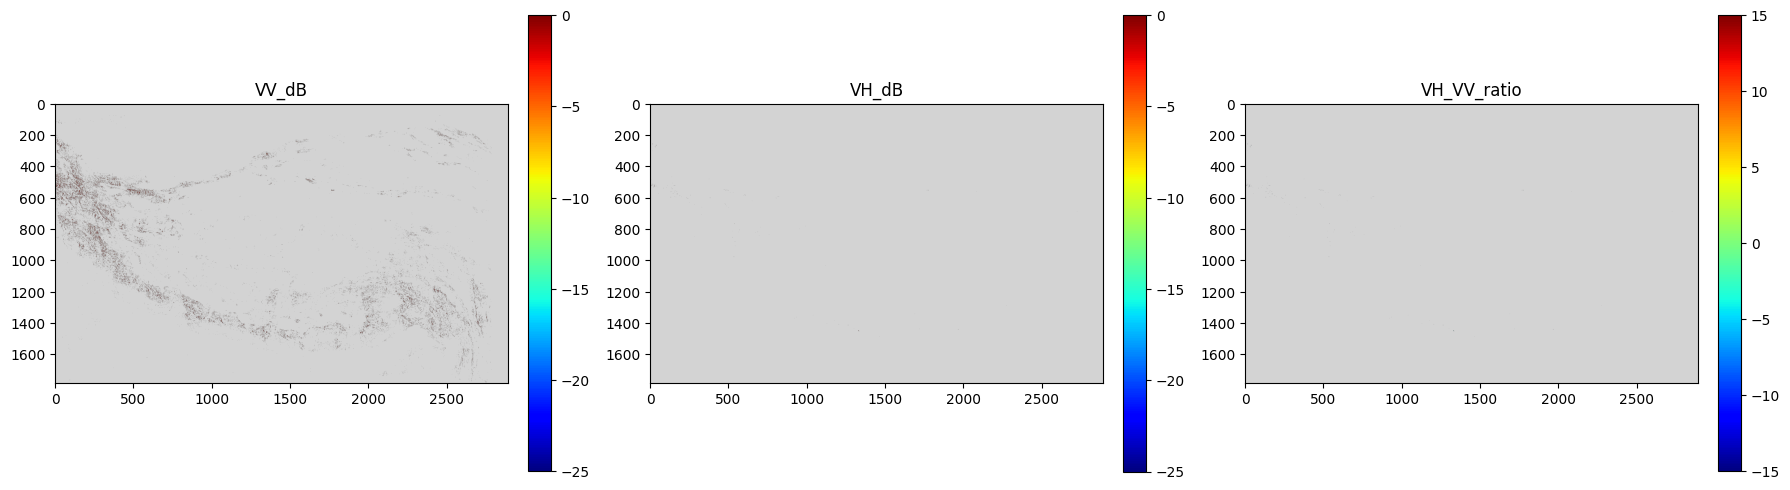

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
import glob
import os

# ============================
# ÏãúÍ∞ÅÌôî Ìï®Ïàò
# ============================
def plot_with_scaling(array, ax, title, band_type="hh", cmap="jet"):
    # NaN Ï†úÍ±∞
    if array is None or np.all(np.isnan(array)):
        ax.set_title(f"{title} (no data)")
        return None

    # Î∞¥Îìú ÌÉÄÏûÖÎ≥Ñ Í≥†Ï†ï Ïä§ÏºÄÏùº
    if band_type.lower() in ["hh", "hv", "vv", "vh"]:
        vmin, vmax = -25, 0
    elif band_type.lower() == "ratio":
        vmin, vmax = -15, 15
    else:
        vmin, vmax = np.nanmin(array), np.nanmax(array)  # fallback

    im = ax.imshow(band, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_facecolor("lightgray")  # NaN ÏòÅÏó≠ ÌöåÏÉâÏúºÎ°ú

    ax.set_title(title)
    return im


# ============================
# 1. Ìè¥Îçî ÎÇ¥ ÌÉÄÏùº Î≥ëÌï©
# ============================
band_name = "cband"   # "cband" or "lband"
in_dir = f"/content/{band_name.upper()}_tiles_1deg"
out_mosaic = f"/content/{band_name.upper()}_mosaic_1km.tif"

tif_files = glob.glob(os.path.join(in_dir, "*.tif"))
src_files = [rasterio.open(f) for f in tif_files]

# Î≥ëÌï© ÏàòÌñâ
mosaic, out_trans = merge(src_files)

# Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Í∞±Ïã†
out_meta = src_files[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "count": mosaic.shape[0]
})

# GeoTIFF Ï†ÄÏû•
with rasterio.open(out_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"‚úÖ Î≥ëÌï© ÏôÑÎ£å: {out_mosaic}")
for src in src_files:
    src.close()

# ============================
# 2. ÏãúÍ∞ÅÌôî
# ============================
if band_name.lower() == "lband":
    band_titles = [("HH_dB", "hh"), ("HV_dB", "hv"), ("HV_HH_ratio", "ratio")]
else:
    band_titles = [("VV_dB", "vv"), ("VH_dB", "vh"), ("VH_VV_ratio", "ratio")]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (title, btype) in enumerate(band_titles):
    band = mosaic[i, :, :].astype(float)
    band[band == 0] = np.nan  # mask ÎπàÍ∞í
    im = plot_with_scaling(band, axes[i], title, band_type=btype)
    if im:
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


Ïó¨Í∏∞Î∂ÄÌÑ∞!

In [41]:
import os
import re
import math
import ee
import geemap
from shapely.geometry import box

# =========================
# 0) EE Ï¥àÍ∏∞Ìôî
# =========================
try:
    ee.Initialize(project = project_id)
except Exception:
    ee.Authenticate(project = project_id)
    ee.Initialize(project = project_id)

# =========================
# 1) ÎåÄÌëú ÏÇ∞Îß• 10Í∞ú ROI (WGS84)
#    (ÏÇ¨Ïö©ÏûêÍ∞Ä Ï†úÍ≥µÌïú Í∑∏ÎåÄÎ°ú)
# =========================
rois = {
    "Andes":                   box(-81, -55, -60,  12),
    "Rocky Mountains":         box(-122, 31, -102, 60),
    "Alps":                    box(   5,  44,   16,  48),
    "Himalaya":                box(  72,  26,   98,  36),
    "Tien Shan":               box(  66,  39,   96,  46),
    "Atlas":                   box( -13,  27,   10,  37),
    "Great Dividing Range":    box( 146, -43,  154, -16),
    "Japanese Alps":           box( 136,  35,  139,  37.5),
    "Drakensberg":             box(  27, -31,   31, -27),
    "Taebaek (Korea)":         box( 127,  35,  130,  39),
}

# 2) Í≥†Ï†ï Ïù∏Îç±Ïä§ (ÌååÏùºÎ™Ö Í∑úÏπôÏóê ÏÇ¨Ïö©)
roi_id_map = {
    "Andes": 1,
    "Rocky Mountains": 2,
    "Alps": 3,
    "Himalaya": 4,
    "Tien Shan": 5,
    "Atlas": 6,
    "Great Dividing Range": 7,
    "Japanese Alps": 8,
    "Drakensberg": 9,
    "Taebaek (Korea)": 10,
}


In [64]:
import ee, geemap, os
from shapely.geometry import box



# -----------------------------
# Ìï®Ïàò: shapely box ‚Üí EE Rect
# -----------------------------
def box_to_ee_rect(b):
    minx, miny, maxx, maxy = b.bounds
    return ee.Geometry.Rectangle([minx, miny, maxx, maxy], proj="EPSG:4326", geodesic=False)

# -----------------------------
# SAR Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± Ìï®Ïàò (Sentinel-1 C-band)
# -----------------------------
def get_s1_cband(roi, start="2018-01-01", end="2018-12-31"):
    s1 = (ee.ImageCollection("COPERNICUS/S1_GRD")
          .filterBounds(roi)
          .filterDate(start, end)
          .filter(ee.Filter.eq("instrumentMode", "IW"))
          .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
          .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))
          .median()
          .clip(roi))
    vv_dB = s1.select("VV")    # Ïù¥ÎØ∏ dB
    vh_dB = s1.select("VH")
    ratio = vh_dB.subtract(vv_dB).rename("VH_VV_ratio")
    return vv_dB.addBands(vh_dB).addBands(ratio), vv_dB  # (ÏµúÏ¢Ö Ïù¥ÎØ∏ÏßÄ, Ïπ¥Ïö¥Ìä∏ Î∞¥Îìú)


def get_palsar2_mosaic(roi, year=2017):
    dataset_id = f"JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/{year}"
    palsar = ee.Image(dataset_id).clip(roi)

    hh_dB = palsar.select("HH")
    hv_dB = palsar.select("HV")
    ratio = hv_dB.subtract(hh_dB).rename("HV_HH_ratio")

    # ‚ö†Ô∏è Ï†àÎåÄ .getInfo() ÏÇ¨Ïö©ÌïòÏßÄ Îßê Í≤É
    return hh_dB.addBands(hv_dB).addBands(ratio), hh_dB


In [47]:
print(rois.items())

dict_items([('Andes', <POLYGON ((-60 -55, -60 12, -81 12, -81 -55, -60 -55))>), ('Rocky Mountains', <POLYGON ((-102 31, -102 60, -122 60, -122 31, -102 31))>), ('Alps', <POLYGON ((16 44, 16 48, 5 48, 5 44, 16 44))>), ('Himalaya', <POLYGON ((98 26, 98 36, 72 36, 72 26, 98 26))>), ('Tien Shan', <POLYGON ((96 39, 96 46, 66 46, 66 39, 96 39))>), ('Atlas', <POLYGON ((10 27, 10 37, -13 37, -13 27, 10 27))>), ('Great Dividing Range', <POLYGON ((154 -43, 154 -16, 146 -16, 146 -43, 154 -43))>), ('Japanese Alps', <POLYGON ((139 35, 139 37.5, 136 37.5, 136 35, 139 35))>), ('Drakensberg', <POLYGON ((31 -31, 31 -27, 27 -27, 27 -31, 31 -31))>), ('Taebaek (Korea)', <POLYGON ((130 35, 130 39, 127 39, 127 35, 130 35))>)])


In [65]:
# -----------------------------
# Î©îÏù∏ Î£®ÌîÑ
# -----------------------------
base_out = r"C:\Users\kom\Downloads\ROI_Tiles_palsar"
os.makedirs(base_out, exist_ok=True)

step = 2          # ÌÉÄÏùº ÌÅ¨Í∏∞: 2¬∞ x 2¬∞
resolution = 1000 # Ï∂úÎ†• Ìï¥ÏÉÅÎèÑ (1km)

#for roi_name, shp_box in rois.items():
from shapely.geometry import Polygon

# ÏòàÏãú Ìè¥Î¶¨Í≥§
#shp_box = Polygon([(98, 26), (98, 36), (72, 36), (72, 26), (98, 26)])

for roi_name, shp_box in rois.items():
    print(f"\n=== ROI: {roi_name} ===")
    print("Polygon bounds:", shp_box.bounds)
    roi = box_to_ee_rect(shp_box)

    # ROIÎ≥Ñ Ï†ÄÏû• Ìè¥Îçî
    out_dir = os.path.join(base_out, roi_name)
    os.makedirs(out_dir, exist_ok=True)

    # Sentinel-1 Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    final_image, band_for_count = get_palsar2_mosaic(roi, year=2009)

    lon_min, lat_min, lon_max, lat_max = shp_box.bounds
    tile_id = 0

    for lon in range(int(lon_min), int(lon_max), step):
        for lat in range(int(lat_min), int(lat_max), step):
            lon0, lon1 = lon, lon + step
            lat0, lat1 = lat, lat + step
            roi_tile = ee.Geometry.Rectangle([lon0, lat0, lon1, lat1])

            try:
                # ÌîΩÏÖÄ Ïπ¥Ïö¥Ìä∏
                count_dict = band_for_count.reduceRegion(
                    reducer=ee.Reducer.count(),
                    geometry=roi_tile,
                    scale=resolution,
                    maxPixels=1e13
                ).getInfo()

                num_pixels = list(count_dict.values())[0] if count_dict else 0
                if num_pixels == 0:
                    print(f"‚è≠Ô∏è Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå: {roi_name} Tile {tile_id} ({lon0}, {lat0})")
                    continue

                # ÌååÏùºÎ™Ö
                fname = os.path.join(out_dir, f"{roi_name}_tile_{tile_id}.tif")

                # Ï†ÄÏû•
                geemap.ee_export_image(
                    final_image,
                    filename=fname,
                    scale=resolution,
                    region=roi_tile,
                    crs="EPSG:4326"
                )
                print(f"‚úÖ Ï†ÄÏû•: {fname} (ÌîΩÏÖÄÏàò: {num_pixels})")

            except Exception as e:
                print(f"‚ùå Ïã§Ìå®: {roi_name} Tile {tile_id} ({lon0}, {lat0})", e)

            tile_id += 1



=== ROI: Andes ===
Polygon bounds: (-81.0, -55.0, -60.0, 12.0)
‚ùå Ïã§Ìå®: Andes Tile 0 (-81, -55) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
‚ùå Ïã§Ìå®: Andes Tile 1 (-81, -53) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
‚ùå Ïã§Ìå®: Andes Tile 2 (-81, -51) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
‚ùå Ïã§Ìå®: Andes Tile 3 (-81, -49) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
‚ùå Ïã§Ìå®: Andes Tile 4 (-81, -47) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not found (does not exist or caller does not have access).
‚ùå Ïã§Ìå®: Andes Tile 5 (-81, -45) Image.load: Image asset 'JAXA/ALOS/PALSAR-2/ALOS2_PALSAR_MOSAIC/2009' not f

Ï∞æÏùÄ ÌååÏùº Ïàò: 4
ÏòàÏãú: ['/content/C:\\Users\\kom\\Downloads\\ROI_Tiles/Taebaek (Korea)/Taebaek (Korea)_tile_2.tif', '/content/C:\\Users\\kom\\Downloads\\ROI_Tiles/Taebaek (Korea)/Taebaek (Korea)_tile_1.tif', '/content/C:\\Users\\kom\\Downloads\\ROI_Tiles/Taebaek (Korea)/Taebaek (Korea)_tile_0.tif']
‚úÖ Î≥ëÌï© ÏôÑÎ£å: /content/C:\Users\kom\Downloads\ROI_TilesTaebaek (Korea)_mosaic.tif
üìâ Îã§Ïö¥ÏÉòÌîå ÏôÑÎ£å: (3, 446, 446)


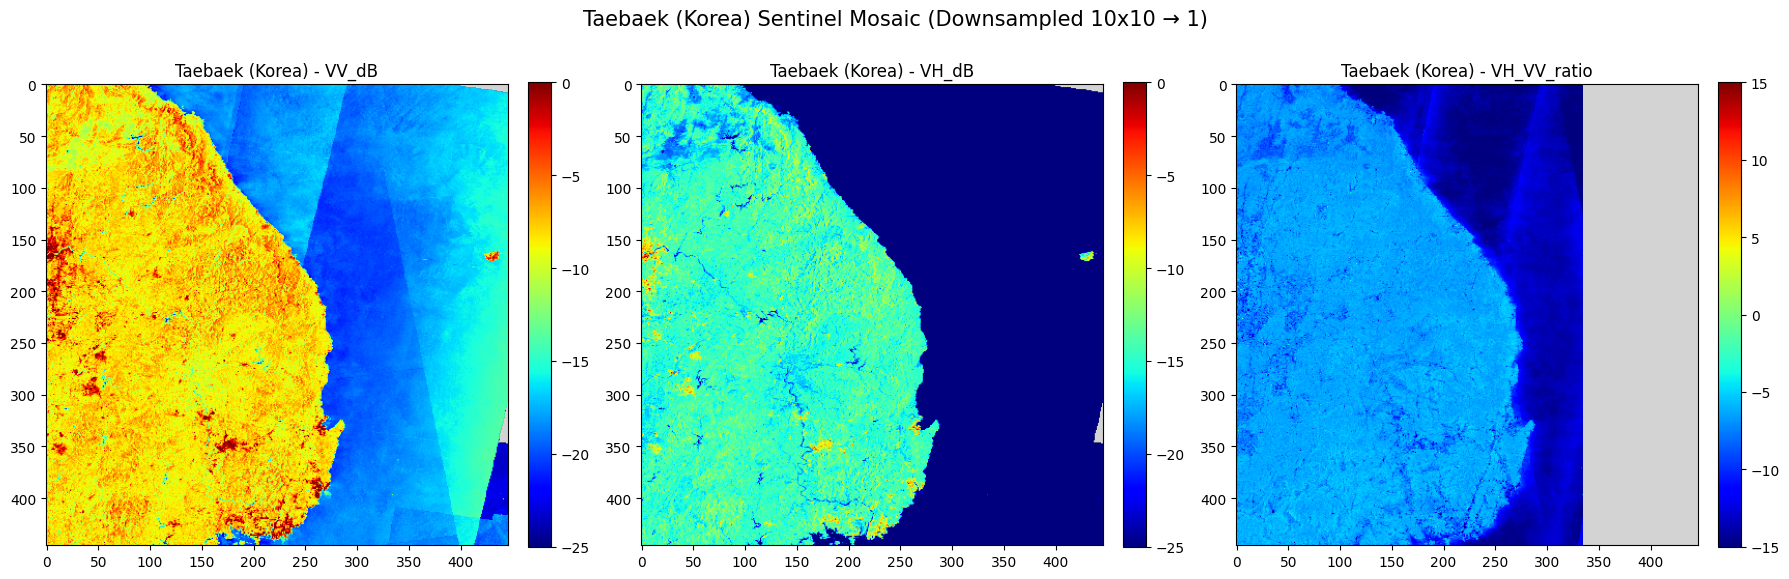

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.enums import Resampling
import glob
import os

# ============================================
# 0. ÏÑ§Ï†ï
# ============================================
region = "Taebaek (Korea)"

in_dir = rf"/content/C:\Users\kom\Downloads\ROI_Tiles/{region}"  # ‚úÖ Ïù¥Í≤å Ïò¨Î∞îÎ•∏ Í≤ΩÎ°ú
out_mosaic = rf"/content/C:\Users\kom\Downloads\ROI_Tiles{region}_mosaic.tif"

import glob, os
tif_files = glob.glob(os.path.join(in_dir, "*.tif"))
print("Ï∞æÏùÄ ÌååÏùº Ïàò:", len(tif_files))
print("ÏòàÏãú:", tif_files[:3])


src_files = [rasterio.open(f) for f in tif_files]
mosaic, out_trans = merge(src_files)

# Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Í∞±Ïã†
out_meta = src_files[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "count": mosaic.shape[0]
})

# Î≥ëÌï© ÌååÏùº Ï†ÄÏû•
with rasterio.open(out_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"‚úÖ Î≥ëÌï© ÏôÑÎ£å: {out_mosaic}")

for src in src_files:
    src.close()

# ============================================
# 2. Ìï¥ÏÉÅÎèÑ Ï∂ïÏÜå (10x10 ÌîΩÏÖÄ ‚Üí 1ÌîΩÏÖÄÎ°ú Ï∂ïÏÜå)
# ============================================
scale_factor = 1  # 10x10 Ï∂ïÏÜå

new_height = mosaic.shape[1] // scale_factor
new_width = mosaic.shape[2] // scale_factor

mosaic_downscaled = np.zeros((mosaic.shape[0], new_height, new_width), dtype=np.float32)

with rasterio.open(out_mosaic) as dataset:
    for i in range(dataset.count):
        mosaic_downscaled[i] = dataset.read(
            i + 1,
            out_shape=(new_height, new_width),
            resampling=Resampling.average
        )

print(f"üìâ Îã§Ïö¥ÏÉòÌîå ÏôÑÎ£å: {mosaic_downscaled.shape}")

# ============================================
# 3. ÏãúÍ∞ÅÌôî Ìï®Ïàò
# ============================================
def plot_with_scaling(array, ax, title, band_type="vv", cmap="jet"):
    if array is None or np.all(np.isnan(array)):
        ax.set_title(f"{title} (no data)")
        return None

    # Ïä§ÏºÄÏùº ÏßÄÏ†ï
    if band_type.lower() in ["hh", "hv", "vv", "vh"]:
        vmin, vmax = -25, 0
    elif band_type.lower() == "ratio":
        vmin, vmax = -15, 15
    else:
        vmin, vmax = np.nanmin(array), np.nanmax(array)

    im = ax.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_facecolor("lightgray")
    ax.set_title(title)
    return im

# ============================================
# 4. ÏãúÍ∞ÅÌôî
# ============================================
# Î∞¥Îìú Íµ¨ÏÑ± Í∞ÄÏ†ï (ÌïÑÏöîÏóê Îî∞Îùº Ï°∞Ï†ï)
band_titles = [("VV_dB", "vv"), ("VH_dB", "vh"), ("VH_VV_ratio", "ratio")]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (title, btype) in enumerate(band_titles):
    if i >= mosaic_downscaled.shape[0]:
        continue
    band = mosaic_downscaled[i, :, :].astype(float)
    band[band == 0] = np.nan
    im = plot_with_scaling(band, axes[i], f"{region} - {title}", band_type=btype)
    if im:
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.suptitle(f"{region} Sentinel Mosaic (Downsampled 10x10 ‚Üí 1)", fontsize=15)
plt.tight_layout()
plt.show()


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:

# 2Ô∏è‚É£ Î≥µÏÇ¨Ìï† Î°úÏª¨ Ìè¥Îçî ÏßÄÏ†ï
import shutil
src_dir = rf"/content/C:\Users\kom\Downloads\ROI_Tiles"
dst_dir = "/content/drive/MyDrive/ROI_Tiles"

# 3Ô∏è‚É£ Ìè¥Îçî Ï†ÑÏ≤¥ Î≥µÏÇ¨
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)

print(f"‚úÖ Î≥µÏÇ¨ ÏôÑÎ£å: {dst_dir}")

‚úÖ Î≥µÏÇ¨ ÏôÑÎ£å: /content/drive/MyDrive/ROI_Tiles


In [37]:
import os
import glob
import rasterio

# ============================================
# 0. ÏÑ§Ï†ï
# ============================================
region = "Andes"
in_dir = rf"/content/C:\Users\kom\Downloads\ROI_Tiles/{region}"   # ‚úÖ Î°úÏª¨ ÌôòÍ≤Ω Í∏∞Ï§Ä
# ‚ö†Ô∏è ColabÏóêÏÑúÎäî C:\Users... Í≤ΩÎ°úÍ∞Ä Ïïà Î®πÌûò. DriveÏóê Ïò¨Î¶∞ Í≤ΩÏö∞ ÏïÑÎûòÎ°ú ÏàòÏ†ï:
# in_dir = f"/content/drive/MyDrive/ROI_Tiles/{region}"

# ============================================
# 1. ÌååÏùº ÌÉêÏÉâ
# ============================================
tif_files = glob.glob(os.path.join(in_dir, "*.tif"))

if not tif_files:
    print(f"‚ùå TIFF ÌååÏùºÏùÑ Ï∞æÏßÄ Î™ªÌñàÏäµÎãàÎã§: {in_dir}")
else:
    print(f"‚úÖ {len(tif_files)}Í∞ú ÌååÏùº Î∞úÍ≤¨")
    print("ÏòàÏãú:", os.path.basename(tif_files[0]))

# ============================================
# 2. Í∞Å ÌååÏùºÏùò Î∞¥Îìú Ï†ïÎ≥¥ Ï∂úÎ†•
# ============================================
for f in tif_files:
    with rasterio.open(f) as src:
        band_count = src.count
        band_names = [src.descriptions[i] if src.descriptions[i] else f"Band {i+1}" for i in range(band_count)]
        print(f"\nüìÇ ÌååÏùº: {os.path.basename(f)}")
        print(f"   - ÌÅ¨Í∏∞: {src.width} x {src.height}")
        print(f"   - Î∞¥Îìú Ïàò: {band_count}")
        print(f"   - Ï¢åÌëúÍ≥Ñ: {src.crs}")
        print(f"   - Î∞¥Îìú Ïù¥Î¶Ñ: {band_names}")


‚úÖ 334Í∞ú ÌååÏùº Î∞úÍ≤¨
ÏòàÏãú: Andes_tile_177.tif

üìÇ ÌååÏùº: Andes_tile_177.tif
   - ÌÅ¨Í∏∞: 224 x 224
   - Î∞¥Îìú Ïàò: 3
   - Ï¢åÌëúÍ≥Ñ: EPSG:4326
   - Î∞¥Îìú Ïù¥Î¶Ñ: ['Band 1', 'Band 2', 'Band 3']

üìÇ ÌååÏùº: Andes_tile_312.tif
   - ÌÅ¨Í∏∞: 224 x 223
   - Î∞¥Îìú Ïàò: 3
   - Ï¢åÌëúÍ≥Ñ: EPSG:4326
   - Î∞¥Îìú Ïù¥Î¶Ñ: ['Band 1', 'Band 2', 'Band 3']

üìÇ ÌååÏùº: Andes_tile_59.tif
   - ÌÅ¨Í∏∞: 224 x 224
   - Î∞¥Îìú Ïàò: 3
   - Ï¢åÌëúÍ≥Ñ: EPSG:4326
   - Î∞¥Îìú Ïù¥Î¶Ñ: ['Band 1', 'Band 2', 'Band 3']

üìÇ ÌååÏùº: Andes_tile_193.tif
   - ÌÅ¨Í∏∞: 224 x 224
   - Î∞¥Îìú Ïàò: 3
   - Ï¢åÌëúÍ≥Ñ: EPSG:4326
   - Î∞¥Îìú Ïù¥Î¶Ñ: ['Band 1', 'Band 2', 'Band 3']

üìÇ ÌååÏùº: Andes_tile_71.tif
   - ÌÅ¨Í∏∞: 223 x 224
   - Î∞¥Îìú Ïàò: 3
   - Ï¢åÌëúÍ≥Ñ: EPSG:4326
   - Î∞¥Îìú Ïù¥Î¶Ñ: ['Band 1', 'Band 2', 'Band 3']

üìÇ ÌååÏùº: Andes_tile_72.tif
   - ÌÅ¨Í∏∞: 223 x 224
   - Î∞¥Îìú Ïàò: 3
   - Ï¢åÌëúÍ≥Ñ: EPSG:4326
   - Î∞¥Îìú Ïù¥Î¶Ñ: ['Band 1', 'Band 2', 'Band 3']

üìÇ ÌååÏùº: Andes_tile_332.tif
   - Ì